In [ ]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Distances
using Random;

In [ ]:
#Hyperparameters
n = 10
N = 1000
σₐ = 0.001
bound = 1000

k_range = 20
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] #November 3
k_list_lite = [i for i in 1:k_range]
k_real = 12
k = k_real;

In [ ]:
#Functions
function plot_data(data,scores,alpha=1.0)
    scatter(data[:,1],data[:,2],c=scores)
end

function sample_data(x, y, n=100)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

mₖ(k) = k*4 + 1;

In [ ]:
#Generative Interpolator Network

#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    #if(typeof(x) == Float64)
        #x = [x]
    #end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, sigmoid),
               Dense(W₂, b₂))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

#Create a Random Network
@gen function generator(x::Array{Float64}, k=12)
    σₖ = 1.0::Float64
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    #scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([0.001 for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

In [ ]:
#Generate Network Parameters and Corresponding Curve
obs = choicemap()::ChoiceMap
x_raw = rand(Uniform(-bound,bound),(N,2))
x = transpose(x_raw)
data = x
data_raw = x_raw

(trace,) = generate(generator, (x, k_real), obs)

Wₕ = trace[:Wₕ]
Wₒ = trace[:Wₒ]
bₕ = trace[:bₕ]
bₒ = trace[:bₒ]

y_real = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])
#print(y_real)

y_fake = rand(Uniform(0,1),(N))
plot_data(x_raw,y_real)

In [ ]:
#Try Sampling the Data
x_samp, y_samp = sample_data(x,y_real)
plot_data(x_samp, y_samp)

In [ ]:
#Classifier Network Tries to Learn the Generator Network

#@dist k_count() = categorical([1/length(k_list) for i=1:length(k_list)]) + 1

@gen function classifier(x::Array{Float64})
    σₖ = 1.0::Float64
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    #k_real = k_list[k]
    k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k_list[k]
    #print(k)
    #k ~ k_count()
    #k_real = k
    #print(k)
    #print(k_real)
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([0.001 for i=1:length(x[1,:])])), (:y))
    
    return y
end;

classifier(x);

In [ ]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs = obs_master;

obs2 = choicemap()::ChoiceMap
obs2[:y] = y_real

#println(y_real)
#println(y_fake)

(trace1,) = generate(classifier, (x,), obs)
(trace2,) = generate(classifier, (x,), obs2)

score1 = exp(get_score(trace1)/length(y_real))
score2 = exp(get_score(trace2)/length(y_real))

println(score1)
println(score2)
println(score1/score2)

In [ ]:
#Register Observed Data
x_samp, y_samp = sample_data(x, y_real)
x_samp = transpose(x_samp)
size(x_samp)
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master
scores = []
distances = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = Flux.σ.(G(x,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k))
best_dist = euclidean(best_pred_y, y_real)

In [ ]:
#Plot of Log Likelihood Scores
x_samp, y_samp = sample_data(x, y_real)
#x_samp, y_samp = x, y_real
x_samp = transpose(x_samp)
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master;

scores = []
distances = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = Flux.σ.(G(x,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k))
best_dist = euclidean(best_pred_y, y_real)

function likelihood(best_dist, best_score, best_k)
    x_samp, y_samp = sample_data(x, y_real)
    #x_samp, y_samp = x, y_real
    x_samp = transpose(x_samp)
    obs_master = choicemap()::ChoiceMap
    obs_master[:y] = y_samp
    obs = obs_master;
    (trace,) = generate(classifier, (x_samp,), obs)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    #print(k)
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))

    #dist = sqrt(sum((pred_y .- y_real) .^ 2))
    dist = euclidean(pred_y, y_real)
    score = get_score(trace)
    #println(score)
    if dist < best_dist
        best_dist = dist
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_k = best_trace[:k]
    end
    #push!(best_ks,best_k)
    push!(scores,score)
    push!(distances,dist)
    push!(ks, k)
    #println(best_score)
    return(best_dist, best_score, best_k)
end

for i=1:60000
    best_dist, best_score, best_k = likelihood(best_dist, best_score, best_k)
    push!(best_ks, best_k)
end

#for j=1:20
    #new_distances1 = [ks[i] == j ? distances[i] : -1 for i=1:length(distances)]
    #new_distances = filter(x -> x != -1, new_distances1)
    #new_scores1 = [ks[i] == j ? scores[i] : 100 for i=1:length(scores)]
    #new_scores = filter(x -> x < 100, new_scores1)
    #scatter(new_distances,new_scores,label=j)
#end
#plt.xlim(0,200)
#plt.ylim(-6000,0)
scatter(distances, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.legend()
#println(best_trace[:k])
#println(best_dist)
#println(best_ks)

In [ ]:
#print(best_ks)
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([best_ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[12].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

In [ ]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(trace)
    current_k = trace[:k]
    if current_k == last(k_list)
        new_trace = death(trace)
    elseif current_k == k_list[1]
        new_trace = birth(trace)
    else
        new_trace = bernoulli(0.5) ? birth(trace) : death(trace)
    end
    return new_trace    
end

@gen function birth(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    #new_k = previous_k + 1
    difference = abs(new_k - previous_k)
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_samp
    obs_new[:Wₕ] = vcat(Wₕ,[rand(1)[1] for i=1:(2*difference)])
    obs_new[:Wₒ] = vcat(Wₒ,[rand(1)[1] for i=1:difference])
    obs_new[:bₕ] = vcat(bₕ,[rand(1)[1] for i=1:difference])
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace

end

@gen function death(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k - 1]
    #new_k = previous_k - 1
    difference = abs(previous_k - new_k)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_samp
    obs_new[:Wₕ] = Wₕ[1:new_k*2]
    obs_new[:Wₒ] = Wₒ[1:new_k]
    obs_new[:bₕ] = bₕ[1:new_k]
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace
end;

In [273]:
traces = []
acc = []
acc_a = []
acc_w = []
ks = []

function within_dimension(trace, iters)
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=0.005, check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
        push!(acc_w, accepted)
    end
    return trace
end

function across_dimension(trace, iters, obs)
    #selection = select(:Wₕ,:bₕ,:Wₒ,:bₒ,:k)
    #args = get_args(trace)
    #argdiffs = map((_) -> NoChange(), args)
    #(new_trace, weight) = regenerate(trace, args, argdiffs, selection)
    
    new_trace = birth_or_death(trace)
    
    #test = true
    for i=1:iters
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=0.005, check=false, observations=obs)
        accepted && (test = false)
    end
    #test && println("Nothing accepted")
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))

    dist = euclidean(pred_y, y_real)
    #println("Old Trace Dist: $dist")
    
    Wₕ = new_trace[:Wₕ]
    Wₒ = new_trace[:Wₒ]
    bₕ = new_trace[:bₕ]
    bₒ = new_trace[:bₒ]
    k = new_trace[:k]
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))

    dist = euclidean(pred_y, y_real)
    #println("New Trace Dist: $dist")
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))
    
    score1 = exp(get_score(trace)/length(y_samp))
    score2 = exp(get_score(new_trace)/length(y_samp))
    score = score2/score1
    #println(score)
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        #println("New k accepted! Current k: $(new_k)")
        push!(acc,true)
        push!(acc_a, true)
    else
        #println("Sticking with the old k!")
        accepted = false
        push!(acc,false)
        push!(acc_a,false)
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    #push!(acc, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        #x_samp, y_samp = sample_data(x, y_real)
        #x_samp = transpose(x_samp)
        #obs_master = choicemap()::ChoiceMap
        #obs_master[:y] = y_samp
        #obs = obs_master;
        if i%200 == 0
            println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            #println("Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            println("Across Acceptance Prob: $(sum(acc_a)/length(acc_a))")
        end
        
        if rand(Uniform(0,1)) > 0.0
            (trace, k) = across_dimension(trace, 20, obs)
        else
            (trace) = within_dimension(trace, 20)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
runs = 10000
#starting_trace = best_trace

x_samp, y_samp = sample_data(x, y_real)
x_samp = transpose(x_samp)
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master
(starting_trace,) = generate(classifier, (x_samp,), obs)
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,runs);

Beginning RJMCMC. Starting k: 14
Epoch 200 Acceptance Prob: 0.18592964824120603
Across Acceptance Prob: 0.18592964824120603
Epoch 400 Acceptance Prob: 0.09273182957393483
Across Acceptance Prob: 0.09273182957393483
Epoch 600 Acceptance Prob: 0.06176961602671119
Across Acceptance Prob: 0.06176961602671119
Epoch 800 Acceptance Prob: 0.04630788485607009
Across Acceptance Prob: 0.04630788485607009
Epoch 1000 Acceptance Prob: 0.037037037037037035
Across Acceptance Prob: 0.037037037037037035
Epoch 1200 Acceptance Prob: 0.030859049207673062
Across Acceptance Prob: 0.030859049207673062
Epoch 1400 Acceptance Prob: 0.02644746247319514
Across Acceptance Prob: 0.02644746247319514
Epoch 1600 Acceptance Prob: 0.023139462163852407
Across Acceptance Prob: 0.023139462163852407
Epoch 1800 Acceptance Prob: 0.02056698165647582
Across Acceptance Prob: 0.02056698165647582
Epoch 2000 Acceptance Prob: 0.018509254627313655
Across Acceptance Prob: 0.018509254627313655
Epoch 2200 Acceptance Prob: 0.0168258299226

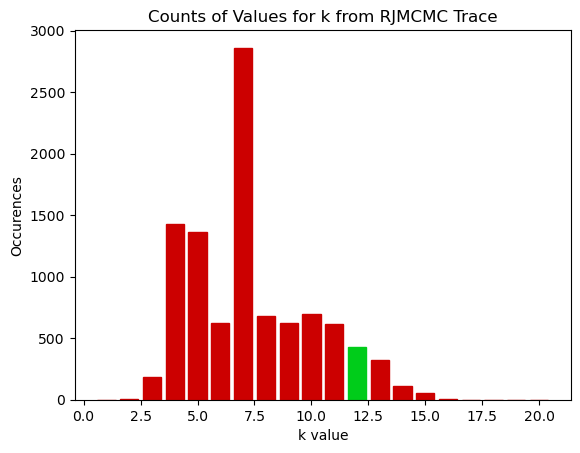

In [274]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[12].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

In [ ]:
Plots.plot(ks)

In [ ]:
scores = [get_score(traces[i]) for i=1:length(traces)]
Plots.plot(scores)

In [ ]:
#Try Dynamic Plotting

anim = @animate for i ∈ 1:runs
    Plots.histogram(ks[1:i], bins=1:20)
end
gif(anim, "anim_fps15.gif", fps = 15)